### Anomaly detection in streaming data

    Anomalies are data patterns that have different data characteristics from normal instances 

In [4]:
pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/8b/ce/15b0bb2fb29b3d46211d8ca740b96b5232499fc49200b58b8d571292c9a6/matplotlib-3.9.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/8d/2f/804f02ff30a7fae21f98198828d0857439ec4c91a96e20cf2d6c49372966/contourpy-1.3.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/63/f1/3a081cd047d83b5966cb0d7ef3fea929ee6eddeb94d8fbfdb2a19bd60cc7/fonttools-4.54.1-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/167.0 kB ? eta -:--:--
     -- ------------------------------------- 10.2/167.0 kB ? eta -:-

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/17/1c/ccdd103cfcc9435a18819856fbbe0c20b8fa60bfc3343580de4be13f0668/scikit_learn-1.5.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for scipy>=1.6.0 from https://files.pythonhosted.org/packages/ea/c2/5ecadc5fcccefaece775feadcd795060adf5c3b29a883bff0e678cfe89af/scipy-1.14.1-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------------------------- ------------ 41.0/60.8 kB 245.8 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 268.8 kB/s eta 0:00:00
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b6


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.ensemble import IsolationForest

### Data Generation (derived from chatgpt.com)
    
Simulating a streaming data scenario by generating synthetic data with the following components:

1. **Regular Pattern (Sine Wave)**: This simulates a periodic pattern in the data stream, resembling real-world signals that exhibit cyclic behavior (e.g., seasonality in time series).
2. **Seasonal Elements**: We introduce a slower sine wave to mimic a longer-term seasonal variation that exists on top of the regular pattern.
3. **Random Noise**: Gaussian noise is added to simulate random variations commonly present in real-world data, making the stream more realistic and challenging for anomaly detection.
4. **Injected Anomalies**: Random spikes or deviations are occasionally introduced to simulate real anomalies in the data stream. These anomalies represent rare, extreme events that the iForestASD algorithm aims to detect.

The `generate_data_stream` function generates the simulated data stream in real-time. It yields one data point at a time to mimic a continuous flow of data, which is ideal for testing the streaming nature of the iForestASD model. 

- **`num_points`**: The total number of data points to generate.
- **`seasonality_period`**: The period of the sine wave, representing regular cyclic behavior. This can be adjusted to simulate different frequencies of regular patterns.
- **`anomaly_rate`**: The probability of injecting an anomaly. This determines how often anomalies occur in the data stream.
- **`noise_level`**: The standard deviation of the Gaussian noise. Higher noise levels simulate more random variation in the data, making anomaly detection more challenging.

### Continuous Data Stream:
By using a generator function (`yield`), we simulate the continuous nature of the data stream. This allows the iForestASD model to process the data incrementally, updating its anomaly detector as new data points arrive.

In [ ]:


# Generator function to simulate a continuous data stream
def continuous_data_stream(values, seasonality_period=200, anomaly_rate=0.01, noise_level=0.1):
    """
    Continuously generates a simulated data stream with regular patterns, seasonal elements, and random noise.
    
    Args:
        seasonality_period (int): The period of the seasonal component.
        anomaly_rate (float): Probability of an anomaly in the data.
        noise_level (float): The standard deviation of the noise.
    
    Yields:
        float: A single data point in the stream.
    """
    
    # Time index, continuously increasing
    t = 0
    
    while True:
        # Regular pattern (sine wave)
        regular_pattern = np.sin(2 * np.pi * t / seasonality_period)

        # Seasonal element (a slower sine wave, simulating seasonal change)
        seasonal_pattern = 0.5 * np.sin(2 * np.pi * t / (seasonality_period * 5))

        # Random noise
        noise = np.random.normal(0, noise_level)

        # Combine regular, seasonal, and noise components
        data_point = regular_pattern + seasonal_pattern + noise

        # Occasionally add anomalies (random spikes)
        if random.random() < anomaly_rate:
            data_point += random.uniform(5, 10)  # Inject an anomaly (a large spike)

        # Yield the data point to simulate continuous streaming
        yield data_point

        # Increment time index
        t += 1


### Model Training

We will be using the model utilized in the following paper:

- [An Anomaly Detection Approach Based on Isolation Forest for Streaming Data Using Sliding Window (Ding & Fei, 2013)](https://www.sciencedirect.com/science/article/pii/S1474667016314999?via%3Dihub)

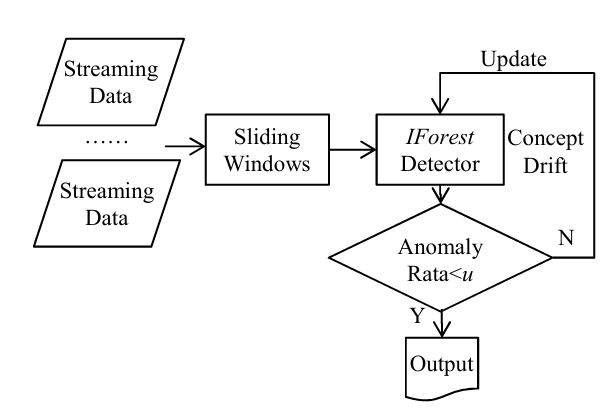

---

Before implementing this, we will first understand the original Isolation Forest model, which is presented in this research paper:

- [Isolation Forest (Liu, Ting, & Zhou, 2011)](https://www.researchgate.net/publication/224384174_Isolation_Forest)

#### Key Concepts:
- Works by isolating attributes, partitioning of instances are repeated recursively until all instances are isolated 
- The algorithm builds an ensemble of of iTrees (or Isolation Trees) for a given data set.
- For each partition it creates an iTree
- Thus anomalies are those instances which have short average path lengths. Since : -
    - fewer the instances of anomalies result in a smaller number of partitions thus shorter paths in tree structure 
    - instances with distinguishable attribute-values are more likely to be separated in early partitioning 

#### Understanding the algorithm:
- Since recursive partitioning can be represented by a tree structure, the number of partitions required to isolate a point is equivalent 
to the path length from the root node to a terminating node


#### Why use this ?
- iForest utilizes no distance/density measures to detect anomalies, thus eliminates major computational cost
- It has as linear time complexity with a low constant & a low memory requirement
- It has the capacity to scale up to handle extremely large data size & high-dimensional problems with a large number of irrelevant attributes


In [10]:
sample_size = 100 # number of samples, for smaller sample sizes usually 50-200 is suitable & handles concept drift well
n_estimators = 200 # number of trees in the forest, since we are working with real-time data, a smaller number of trees is suitable data, 200 estimators is a good balance between accuracy and speed
contamination = 'auto' # percentage of outliers in the data, 'auto' is best initially, as the model will automatically determine the percentage of outliers in the data

model = IsolationForest(n_estimators=n_estimators, max_samples = sample_size,contamination=contamination)